In [15]:
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
import torchvision.transforms as T
import time
from matplotlib.patches import Rectangle
import json
from torch.utils.data import DataLoader

data_path = "/home/kevin/deep_learning/wildcam_eccv/"

# Make WildCam Dataset

In [16]:
class WildcamDetectionDataset(Dataset):
    """Wildcam Image Dataset"""

    def __init__(self, label_file, root_dir, transform=None, transform_size=None):
        self.root_dir = root_dir
        self.transform = transform
        self.transform_size = transform_size
        with open(label_file) as f:
            labels = json.load(f)
        cats = pd.DataFrame(labels['categories'])
        df = pd.DataFrame.from_dict(labels['annotations'])
        # only keep pics with boxes
        keep = [type(elem) == list for elem in df['bbox']]
        df = df.loc[keep]
        print(df.shape)
        # get list of images
        self.images = list(df['image_id'])
        
        # generate labels
        # function for box adjustments
        def adjust_box(b):
            """ Adjust box format to x1, y1, x2, y2 instead of width and heigth"""
            if type(b) == list:
                b[2] = b[0] + b[2]
                b[3] = b[1] + b[3]
            else:
                b = []
            return b
        
        boxes = list(df['bbox'])
        boxes = [adjust_box(b) for b in boxes]
        boxes = [torch.Tensor(b) for b in boxes]
        boxes = torch.stack(boxes)

        # ids
        ids = list(df['category_id'])
        # change ids to all 1 as currently this dataset only contains boxes of animals
        ids = [1 for x in ids]
        
        # make list of dicts
        labels = []
        for i in range(len(boxes)):
            tmp = {'boxes': torch.stack([boxes[i]]),
                  'labels': torch.Tensor([ids[i]]).to(torch.int64)}
            labels.append(tmp)
        self.labels = labels

    
    def resize_bb(self, label, im_size):
        """Resize a bounding box"""
        for b in label['boxes']:
            x_ = self.transform_size / im_size[0]  
            y_ = self.transform_size / im_size[1]
            b[0] = b[0] * y_
            b[1] = b[1] * x_
            b[2] = b[2] * y_
            b[3] = b[3] * x_
        return label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """ Get an image"""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load image
        img = self.images[idx]+".jpg"
        image = Image.open(os.path.join(self.root_dir, img))
        label = self.labels[idx]

        # Apply transform
        if self.transform is not None:
            im_size = np.array(image).shape
            # Transform image
            image = self.transform(image)
            if self.transform_size is not None:
                # Resize labels    
                label = self.resize_bb(label, im_size)

        return {'image': image, 'label': label}

In [17]:
def wildcam_collate_fn(batch):
    imgs = [item['image'] for item in batch]
    targets = [item['label'] for item in batch]
    return imgs, targets


def dict_on_gpu(d, device):
    d['boxes'] = d['boxes'].to(device)
    d['labels'] = d['labels'].to(device)
    return(d)

def freeze_layers(model):
    "Freeze Backbone with FPN"
    for i, child in enumerate(model.children()):
        if i <= 1:
            for param in child.parameters():
                param.requires_grad = False
                
    return model

# Training
With a custom Dataset/DataLoader that works with the pre-trained FasterRCNN model, I can test around with training the model.

In [ ]:
# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get the model
n_classes = 2
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.train()
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=n_classes, bias=True)
model.to(device)

# Freeze Backbone+FPN layers
model = freeze_layers(model)

# Create new dataset with bigger batches
root_dir = "/home/kevin/deep_learning/wildcam_eccv/eccv_18_cropped/"
label_file = os.path.join(data_path, "eccv_18_annotation_files/train_annotations.json")
batch_size = 4
transform = T.Compose([T.Resize((224, 224)),T.ToTensor()])
data = WildcamDetectionDataset(label_file=label_file, root_dir=root_dir, transform=transform, transform_size=224)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, collate_fn=wildcam_collate_fn)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss_list = []

for epoch in range(10):
    for i, batch in enumerate(dataloader):
        images = batch[0]
        labels = batch[1]
        images = [img.to(device) for img in images]
        labels = [dict_on_gpu(lab, device) for lab in labels]

        optimizer.zero_grad()
        
        loss_dict = model(images, labels)

        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        if i % 50 == 0:
            print(f"Epoch: {epoch}, Step: {i}, Loss: {losses.item()}")
            loss_list.append(losses.item())

(12617, 4)
Epoch: 0, Step: 0, Loss: 0.6804391145706177


# Evaluate trained model

[ 35.546234 123.06768   60.33783  153.4951  ]
tensor(1, device='cuda:0')
[210.93607  98.55066 224.      117.6325 ]
tensor(1, device='cuda:0')
[  9.217416   0.       221.698    224.      ]
tensor(1, device='cuda:0')


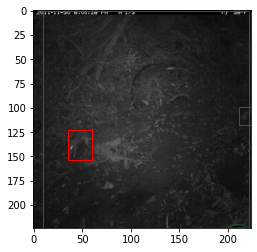

[107.22046 113.24134 137.37622 172.59135]
tensor(1, device='cuda:0')
[  9.809271 171.97284   68.82073  223.25455 ]
tensor(1, device='cuda:0')
[196.8424   120.776596 222.71684  184.96246 ]
tensor(1, device='cuda:0')


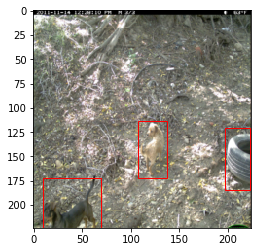

[ 98.818214 100.32986  118.031944 125.7416  ]
tensor(1, device='cuda:0')
[  1.6426673   9.799325  222.12968   224.       ]
tensor(1, device='cuda:0')
[166.27753  64.2801  177.31671  83.03871]
tensor(1, device='cuda:0')
[ 97.695625  81.52541  119.45351  124.36379 ]
tensor(1, device='cuda:0')


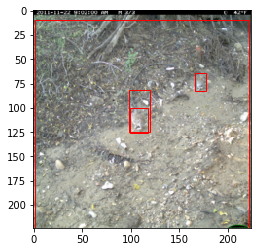

[ 21.397825 147.34009   48.30884  175.78969 ]
tensor(1, device='cuda:0')


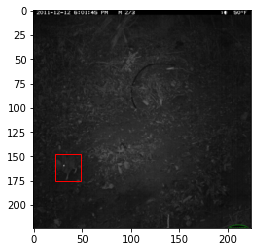

[209.79643   99.96532  224.       119.255135]
tensor(1, device='cuda:0')
[115.97233   84.80466  142.21881  109.842804]
tensor(1, device='cuda:0')
[116.47132   95.319016 130.16779  119.6999  ]
tensor(1, device='cuda:0')
[ 21.479969   0.       223.85635  181.67468 ]
tensor(1, device='cuda:0')
[113.735825  89.22539  132.74776  115.17606 ]
tensor(1, device='cuda:0')


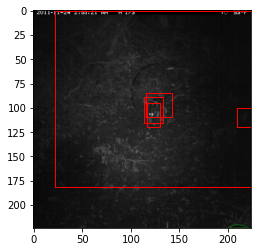

[148.25009 113.61875 178.1003  169.5085 ]
tensor(1, device='cuda:0')
[159.61128   80.964195 191.41824  107.27452 ]
tensor(1, device='cuda:0')
[ 38.23979   0.      224.      189.4609 ]
tensor(1, device='cuda:0')


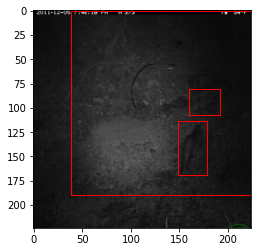

[125.02284   99.950294 150.40048  149.09041 ]
tensor(1, device='cuda:0')
[  5.8640466   0.        213.80406   224.       ]
tensor(1, device='cuda:0')
[125.11675 111.26161 142.4592  144.51271]
tensor(1, device='cuda:0')
[132.7581   99.38187 149.00302 136.15004]
tensor(1, device='cuda:0')
[101.943405  89.68524  120.340195 107.47941 ]
tensor(1, device='cuda:0')
[146.5273   117.209175 164.08353  133.20018 ]
tensor(1, device='cuda:0')


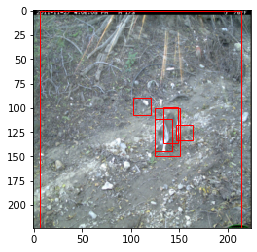

[ 48.109737 116.67358   70.48469  142.86307 ]
tensor(1, device='cuda:0')
[ 93.94913   87.764534 110.29402  111.57445 ]
tensor(1, device='cuda:0')
[ 11.924208   0.       220.89023  224.      ]
tensor(1, device='cuda:0')


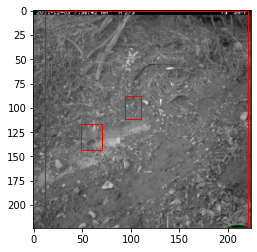

[117.56364 133.65562 133.79582 161.66252]
tensor(1, device='cuda:0')
[138.28964  84.94034 164.4841  105.66897]
tensor(1, device='cuda:0')


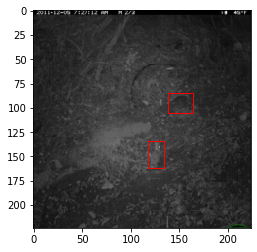

[145.55653   84.492325 169.04263  137.97473 ]
tensor(1, device='cuda:0')
[197.49507  126.091415 222.55244  187.09395 ]
tensor(1, device='cuda:0')
[  1.603728  17.426573 224.       215.65106 ]
tensor(1, device='cuda:0')


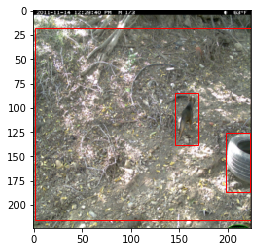

In [5]:


it = iter(dataloader)
## a few examples
model.eval()
model.to(device)

for i in range(10):
    sample = next(it)
    image = [x.to(device) for x in sample[0]]
    pred = model(image)
    pred_boxes = pred[0]['boxes'].cpu().detach().numpy()
    labels = pred[0]['labels']
    plt.imshow(sample[0][0].permute(1, 2, 0))
    
    # Get the current reference
    ax = plt.gca()

    for i in range(len(pred_boxes)):
        box = pred_boxes[i]
        lab = labels[i]
        print(box)
        print(lab)
        box_width = box[2] - box[0]
        box_height = box[3] - box[1]

        # Create a Rectangle patch
        rect = Rectangle((box[0],box[1]),box_width, box_height,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()

[ 35.873043 119.040054  60.00176  159.36646 ]
tensor(3)
[ 38.48162  119.241104 101.39376  158.55905 ]
tensor(3)
[ 33.12304   36.300957 195.55367  181.49075 ]
tensor(4)
[ 32.01015  36.23018 193.25397 178.43013]
tensor(2)
[ 27.117155  30.216253 204.01802  181.93092 ]
tensor(3)


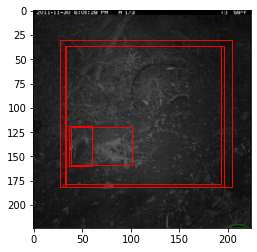

[109.243805 116.015945 135.35081  164.70667 ]
tensor(18)
[198.19044  127.508965 223.64624  179.78133 ]
tensor(51)
[198.21507 128.03629 223.18433 180.00746]
tensor(86)
[106.8574   115.342896 135.12888  167.52182 ]
tensor(16)


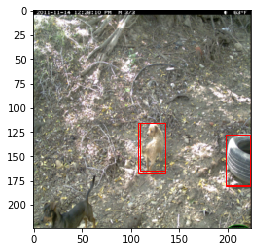

[111.18313   72.477905 134.40845  100.30243 ]
tensor(16)
[ 22.699606 153.69383   32.687138 163.47992 ]
tensor(37)
[101.32755  71.33188 135.31473 110.18535]
tensor(16)


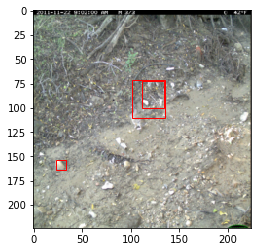

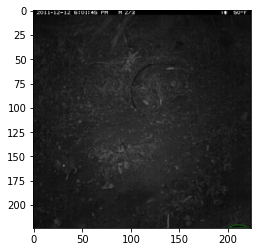

[198.59178 220.13914 221.48868 223.92274]
tensor(34)


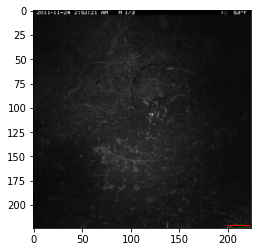

[ 98.29572   55.863808 158.90276  113.50724 ]
tensor(2)
[150.00523 115.84333 177.97447 165.73346]
tensor(18)
[ 99.057    54.47857 165.77617 114.85634]
tensor(43)
[100.10737  53.04432 124.44433 100.55203]
tensor(43)
[102.23651  57.32424 162.51198 115.76529]
tensor(62)
[151.49947 116.75787 175.1218  166.24202]
tensor(19)


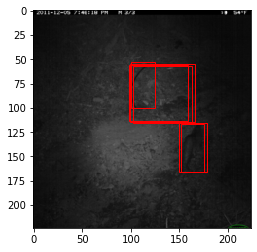

[131.00768  93.32844 150.48436 147.33629]
tensor(16)


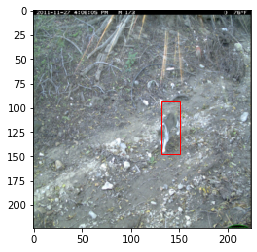

[199.28624 220.69484 222.02574 223.85677]
tensor(34)


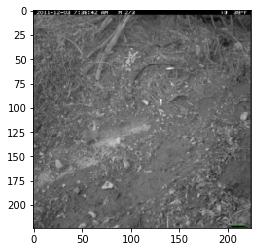

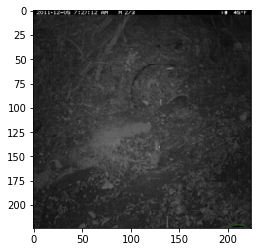

[200.16801 129.33357 223.6202  179.32649]
tensor(51)
[200.44327 128.78053 222.91618 180.63284]
tensor(86)
[ 98.7843   57.305   168.41757 136.05809]
tensor(16)
[200.43579 117.93162 223.3409  179.80621]
tensor(64)
[ 98.75477  56.29754 167.37482 136.02579]
tensor(62)


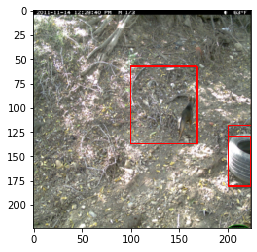

In [8]:
device = "cpu"
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
it = iter(dataloader)
## a few examples
model2.eval()
model2.to(device)

for i in range(10):
    sample = next(it)
    image = [x.to(device) for x in sample[0]]
    pred = model2(image)
    pred_boxes = pred[0]['boxes'].cpu().detach().numpy()
    labels = pred[0]['labels']
    plt.imshow(sample[0][0].permute(1, 2, 0))
    
    # Get the current reference
    ax = plt.gca()

    for i in range(len(pred_boxes)):
        box = pred_boxes[i]
        lab = labels[i]
        print(box)
        print(lab)
        box_width = box[2] - box[0]
        box_height = box[3] - box[1]

        # Create a Rectangle patch
        rect = Rectangle((box[0],box[1]),box_width, box_height,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()